Il progetto utilizza i dati raccolti dall'European Social Survey European Research Infrastructure Consortium tra il 2023 e il 2024. La ricerca ha coinvolto 31 paesi europei (Austria, Belgio, Croazia, Cipro, Finlandia, Francia, Germania, Grecia, Irlanda, Islanda, Italia, Lituania, Norvegia, Paesi Bassi, Polonia, Portogallo, Regno Unito, Serbia, Slovacchia, Slovenia, Spagna, Svezia, Svizzera, Ungheria) e riguarda condizioni e indicatori sociali, comportamenti e attitudini, salute e benessere generale, comportamenti e attitudini politiche, identità culturale e nazionale, disuguaglianze ed esclusione sociale, religioni e valori, e altro ancora.

*European Social Survey European Research Infrastructure (ESS ERIC) (2024) ESS11 - integrated file, edition 2.0 [Data set]. Sikt - Norwegian Agency for Shared Services in Education and Research. https://doi.org/10.21338/ess11e02_0.*

I dati sono quindi reali, ma sono stati anonimizzati. I nomi delle persone sono stati sostituiti da un numero identificativo (variabile 'idno'); dati come la regione di residenza e il reddito annuo sono stati invece generalizzati. Altri dati come l'anno di nascita o l'appartenenza a un gruppo minoritario sono invece ancora presenti e non generalizzati, ma per il numero di sample non sono degli identificatori.

La domanda che ci guiderà è: **quali profili di persone è possibile delineare nei paesi coinvolti nella ricerca, in base alla loro fiducia nelle persone e nelle istituzioni, alla loro soddisfazione, alla loro partecipazione alla società, etc.?**

Per provare a rispondere, faremo innanzitutto clustering con K-means; in seguito aggiungeremo l'etichetta corrispondente al cluster assegnato al DataFrame e addestreremo un modello di apprendimento supervisionato, Random Forest, a predire il cluster di appartenenza di ciascun individuo; infine applicheremo e confronteremo tra loro tecniche di spiegabilità globali e locali per provare a capire in base a quali feature le persone sono state raggruppate.

# Setup

In [ ]:
!pip install lime
!pip install shap
!pip install numpy

#Import

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay
import lime
import shap
import warnings
warnings.filterwarnings('ignore')

#Caricamento del dataset

Scarichiamo il file contenente il dataset tramite gdown e lo rendiamo un dataframe.

In [ ]:
!gdown 14fWTofqiWGO_LZsLcbBcOQ6BVSaB-uQz

Downloading...
From: https://drive.google.com/uc?id=14fWTofqiWGO_LZsLcbBcOQ6BVSaB-uQz
To: /content/ESS11.csv
100% 60.5M/60.5M [00:00<00:00, 210MB/s]


In [ ]:
df = pd.read_csv('/content/ESS11.csv', header=0)
df.head(15)

,idno,cntry,dweight,pspwght,pweight,anweight,nwspol,netusoft,netustm,ppltrst,...,rinwe,inwde,jinws,jinwe,inwtm,mode,domain,prob,stratum,psu
0,50014,AT,1.185115,0.392891,0.330915,0.130013,90,5,180,5,...,NaN,2023-11-12 15:26:55,2023-11-12 15:21:28,2023-11-12 15:26:55,30.0,1,2.0,0.000579,107,317
1,50030,AT,0.609898,0.325153,0.330915,0.107598,90,5,570,10,...,NaN,2023-10-18 10:44:18,2023-10-18 10:42:22,2023-10-18 10:44:18,40.0,1,1.0,0.001124,69,128
2,50057,AT,1.392330,4.000023,0.330915,1.323666,30,5,30,6,...,NaN,2023-09-30 14:13:33,2023-09-30 14:08:31,2023-09-30 14:13:33,42.0,1,2.0,0.000493,18,418
3,50106,AT,0.556061,0.176228,0.330915,0.058316,15,1,6666,6,...,NaN,2023-06-30 15:11:21,2023-06-30 15:08:05,2023-06-30 15:11:21,34.0,1,1.0,0.001233,101,295
4,50145,AT,0.722795,1.060940,0.330915,0.351080,60,5,120,6,...,NaN,2023-07-11 11:14:03,2023-07-11 11:10:02,2023-07-11 11:14:03,57.0,1,2.0,0.000949,115,344
5,50158,AT,0.992605,1.392813,0.330915,0.460902,120,5,120,8,...,NaN,2023-10-16 09:42:52,2023-10-16 09:38:14,2023-10-16 09:42:52,57.0,1,2.0,0.000691,7,373
6,50211,AT,0.540318,0.577186,0.330915,0.190999,45,1,6666,7,...,NaN,2023-10-20 18:46:40,2023-10-20 18:44:11,2023-10-20 18:46:40,25.0,1,2.0,0.001269,58,86
7,50212,AT,0.814622,0.619486,0.330915,0.204997,120,5,240,8,...,NaN,2023-10-26 16:29:37,2023-10-26 16:19:59,2023-10-26 16:29:37,68.0,1,2.0,0.000842,38,3
8,50213,AT,1.364956,0.693635,0.330915,0.229534,20,5,180,7,...,NaN,2023-09-09 15:59:13,2023-09-09 15:57:18,2023-09-09 15:59:13,40.0,1,2.0,0.000502,62,108
9,50235,AT,0.872949,0.492267,0.330915,0.162898,120,1,6666,3,...,NaN,2023-10-08 12:00:13,2023-10-08 11:57:05,2023-10-08 12:00:13,36.0,1,2.0,0.000786,105,314


## Scelta delle variabili
Per non introdurre un bias dovremmo lasciare che kmeans usi tutte le feature a disposizione (tranne quelle amministrative o di identificazione); tuttavia, date le risorse limitate, selezioniamo fin da subito alcune feature che riguardano ambiti diversi della vita delle persone intervistate. Per ogni ambito sono state selezionate da una a quattro feature il quanto più possibile rappresentative:

### Media and social trust
1. **ppltrst**: Using this card, generally speaking, would you say that most people can be trusted, or that you can't be too careful in dealing with people? Please tell me on a score of 0 to 10, where 0 means you can't be too careful and 10 means that most people can be trusted. [likert, 0-10]

### Politics
2. **trstplt**: Using this card, please tell me on a score of 0-10 how much you personally trust politicians. 0 means you do not trust an institution at all, and 10 means you have complete trust. [likert, 0-10]
3. **lrscale**: In politics people sometimes talk of 'left' and 'right'. Using this card, where would you place yourself on this scale, where 0 means the left and 10 means the right? [likert, 0-10]

### Subjective well-being, social exclusion, religion, national and ethnic identity
4. **happy**: Taking all things together, how happy would you say you are? 0 means extremely unhappy, 10 means extremely happy. [likert, 0-10]
5. **sclmeet**: Using this card, how often do you meet socially with friends, relatives or work colleagues? 1 means never, 7 means every day [likert, 1-7]
6. **atchctr**: How emotionally attached do you feel to your country? Please choose a number from 0 to 10, where 0 means not at all emotionally attached and 10 means very emotionally attached. [likert, 0-10]
7. **rlgdgr**: Regardless of whether you belong to a particular religion, how religious would you say you are? 0 means not at all, 10 means very religious. [likert, 0-10]

### Health and inequality
8. **ctrlife**: Using a scale of 0 to 10, where 0 means no control at all and 10 means complete control, how much control do you feel you have over your life in general nowadays? [likert, 0-10]
9. **dosprt**: On how many of the last 7 days did you walk quickly, do sports or other physical activity for 30 minutes or longer? [days, 0-7]

### Gender in contemporary Europe
10. **likrisk**: I like to take risks. 0 means not at all, 6 means completely. [likert, 0-6]
11. **liklead**: I like to be a leader. 0 means not at all, 6 means completely, [likert, 0-6]
12. **sothnds**: I am sensitive to others' needs. 0 means not at all, 6 means completely. [likert 0-6]

### Socio-demographics
13. **domicil**: Which phrase on this card best describes the area where you live? [1-5]
14. **hincfel**: Which of the descriptions on this card comes closest to how you feel about your household's income nowadays? 1 means living comfortably on present income, 4 means very difficult. [likert, 1-4]

### Human values
15. **impricha**: Now I will briefly describe some people. Please listen to each description and tell me how much each person is or is not like you. It is important to her/him to be rich. She/he wants to have a lot of money and expensive things. 1 means very much like me, 6 means not like me at all. [likert, 1-6]
16. **ipeqopta**: She/he thinks it is important that every person in the world should be treated equally. She/he believes everyone should have equal opportunities in life. [likert, 1-6]


È stata scelta almeno una variabile per ogni sezione del questionario (tranne quelle amministrative), per fare in modo che rappresentino effettivamente aspetti diversi delle vite delle persone. Verificheremo anche che le variabili scelte non siano correlate tra loro.

In questo modo, pur avendo selezionato un piccolo sottoinsieme di feature, ci assicuriamo di coprire gli aspetti più importanti della vita privata delle persone: la loro soddisfazione, la loro felicità, quanto si sentono libere, la fiducia interpersonale e istituzionale, la partecipazione sociale e la loro religiosità.

In [ ]:
# Selezioniamo le colonne con le feature scelte e creiamo un nuovo dataframe
selected_columns = ['ppltrst', 'trstplt', 'lrscale', 'happy', 'sclmeet', 'atchctr','rlgdgr', 'ctrlife', 'dosprt', 'likrisk', 'liklead', 'sothnds', 'domicil', 'hincfel', 'impricha', 'ipeqopta']
df_selected = df[selected_columns]
df_selected.head(15)

,ppltrst,trstplt,lrscale,happy,sclmeet,atchctr,rlgdgr,ctrlife,dosprt,likrisk,liklead,sothnds,domicil,hincfel,impricha,ipeqopta
0,5,5,5,8,4,10,5,8,3,2,4,4,3,1,5,2
1,10,1,0,9,7,8,0,8,5,0,0,6,1,2,4,2
2,6,4,3,9,4,9,8,9,3,0,3,6,3,1,4,1
3,6,3,5,7,6,10,6,8,3,0,1,6,1,2,4,2
4,6,5,2,9,5,10,1,9,3,1,0,6,4,2,4,2
5,8,5,4,8,6,8,3,8,4,2,4,5,4,1,2,2
6,7,4,4,7,4,9,6,8,4,1,2,5,3,2,4,3
7,8,7,3,8,4,10,6,8,2,0,4,5,4,1,6,1
8,7,3,5,8,4,8,5,9,2,2,1,3,4,2,3,1
9,3,8,5,7,3,10,10,9,1,0,0,4,4,2,4,1


In [ ]:
print(df_selected.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40156 entries, 0 to 40155
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   ppltrst   40156 non-null  int64
 1   trstplt   40156 non-null  int64
 2   lrscale   40156 non-null  int64
 3   happy     40156 non-null  int64
 4   sclmeet   40156 non-null  int64
 5   atchctr   40156 non-null  int64
 6   rlgdgr    40156 non-null  int64
 7   ctrlife   40156 non-null  int64
 8   dosprt    40156 non-null  int64
 9   likrisk   40156 non-null  int64
 10  liklead   40156 non-null  int64
 11  sothnds   40156 non-null  int64
 12  domicil   40156 non-null  int64
 13  hincfel   40156 non-null  int64
 14  impricha  40156 non-null  int64
 15  ipeqopta  40156 non-null  int64
dtypes: int64(16)
memory usage: 4.9 MB
None


Apparentemente non ci sono missing values, ma ai fini della nostra analisi è opportuno rimuovere i valori che rappresentano una mancata risposta, ossia:
* 66: Not applicable
* 77: Refusal
* 88: Don't know
* 99: No answer

In [ ]:
# Rimuoviamo le righe che contengono 66, 77, 88, 99
df_selected = df_selected[~df_selected.isin([66, 77, 88, 99]).any(axis=1)]

print('\nNuovo DataFrame')
print(df_selected.shape)



Nuovo DataFrame
(33687, 16)


Per le variabili la cui scala non arriva a 6, dobbiamo rimuovere le righe che contengono 7, 8 e 9, che indicano rispettivamente 'Refusal', 'Don't know' e 'No answer'.

In [ ]:
vars = ['likrisk', 'liklead', 'sothnds', 'domicil', 'hincfel']
mask = df_selected[vars].isin([7, 8, 9])
rows_to_remove = mask.any(axis=1)

df_selected = df_selected[~rows_to_remove]

Vediamo quante righe abbiamo rimosso in totale.

In [ ]:
removed = df.shape[0] - df_selected.shape[0]
print(f'Abbiamo rimosso {removed} sample su {df.shape[0]}, ossia il {removed/df.shape[0] * 100:.2f}%')

Abbiamo rimosso 6873 sample su 40156, ossia il 17.12%


È una quantità non indifferente, ma il numero di sample resta comunque molto grande, visto anche che l'obiettivo non è la predizione su questi dati ma il clustering. Inoltre, in questo modo evitiamo di introdurre delle assunzioni sui dati che potrebbero distorcere le spiegazioni.

In [ ]:
df_selected.describe()

,ppltrst,trstplt,lrscale,happy,sclmeet,atchctr,rlgdgr,ctrlife,dosprt,likrisk,liklead,sothnds,domicil,hincfel,impricha,ipeqopta
count,33283.000000,33283.000000,33283.000000,33283.000000,33283.000000,33283.000000,33283.000000,33283.000000,33283.000000,33283.000000,33283.000000,33283.000000,33283.000000,33283.000000,33283.000000,33283.000000
mean,5.288556,3.859448,5.033501,7.558303,4.824175,7.912027,4.699005,7.499264,3.291500,2.687708,3.115615,4.507556,2.940630,1.817685,4.180212,1.935883
std,2.358098,2.439241,2.234869,1.721747,1.542198,2.122293,3.130183,1.897284,2.587173,1.781294,1.767451,1.213133,1.208764,0.780596,1.301923,0.973249
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,2.000000,4.000000,7.000000,4.000000,7.000000,2.000000,7.000000,1.000000,1.000000,2.000000,4.000000,2.000000,1.000000,3.000000,1.000000
50%,5.000000,4.000000,5.000000,8.000000,5.000000,8.000000,5.000000,8.000000,3.000000,3.000000,3.000000,5.000000,3.000000,2.000000,4.000000,2.000000
75%,7.000000,6.000000,6.000000,9.000000,6.000000,10.000000,7.000000,9.000000,6.000000,4.000000,4.000000,5.000000,4.000000,2.000000,5.000000,2.000000
max,10.000000,10.000000,10.000000,10.000000,7.000000,10.000000,10.000000,10.000000,7.000000,6.000000,6.000000,6.000000,5.000000,4.000000,6.000000,6.000000


#EDA

Utilizziamo una correlation heatmap per visualizzare la correlazione tra le feature.

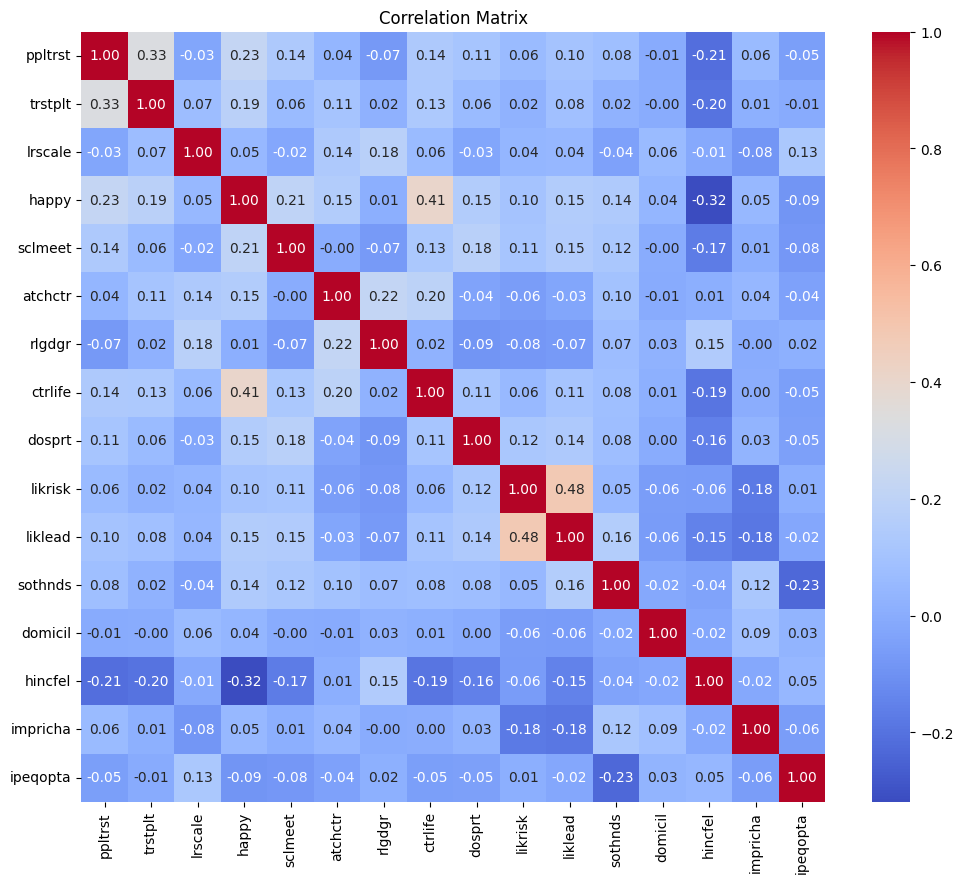

In [ ]:
# Correlation matrix heatmap for numerical features
correlation_matrix = df_selected.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In questo modo abbiamo la conferma che non ci sono variabili con correlazioni molto alte.


Visualizziamo adesso la distribuzione di ciascuna feature tramite degli istogrammi.

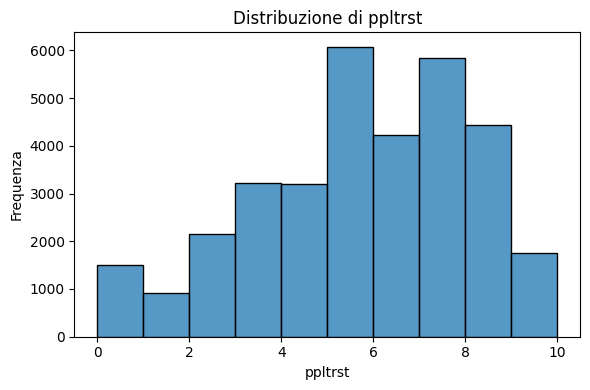

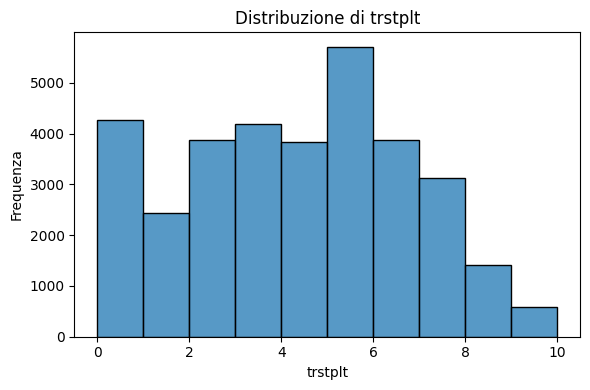

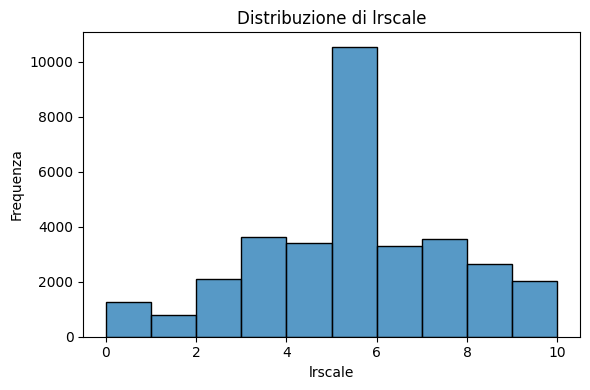

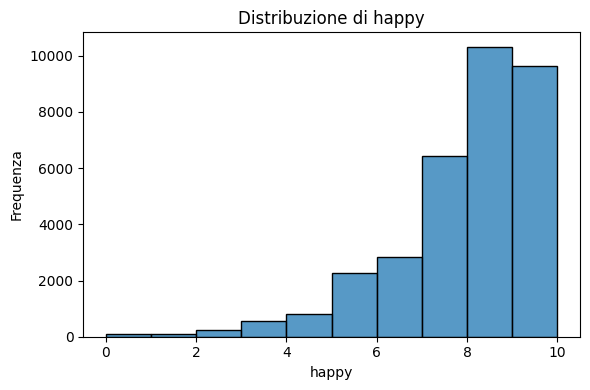

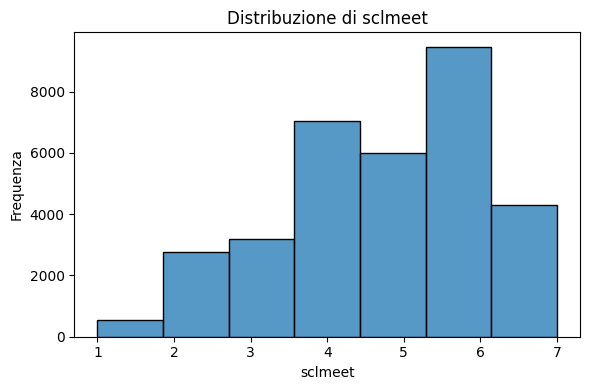

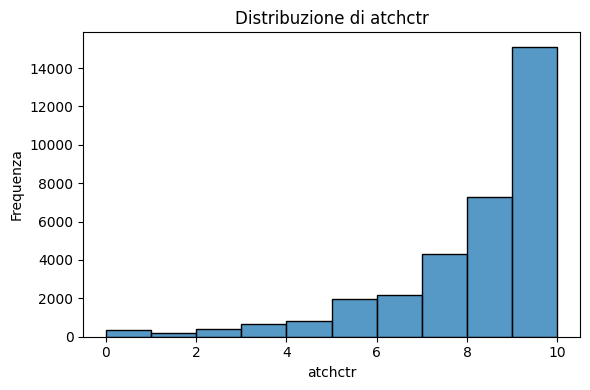

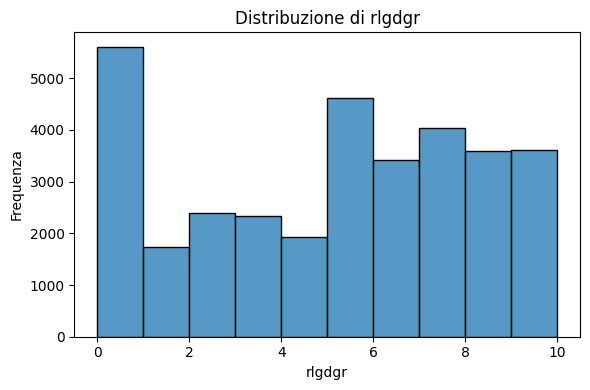

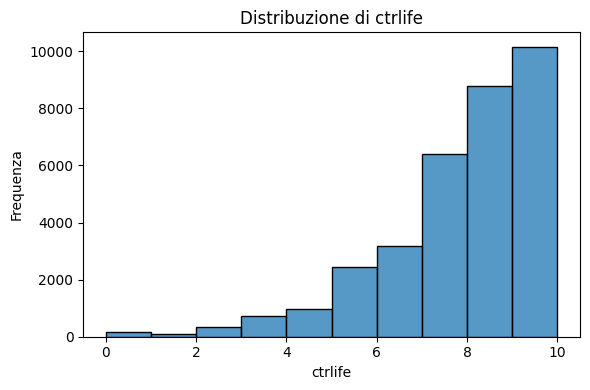

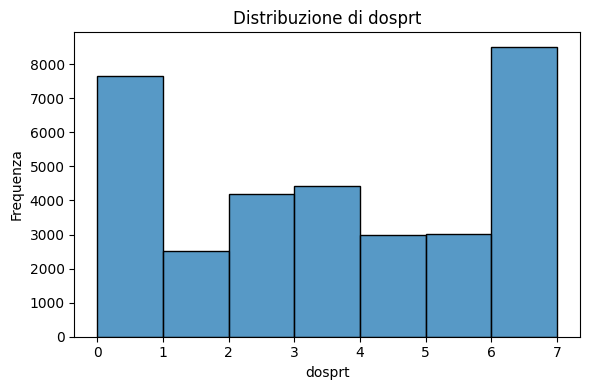

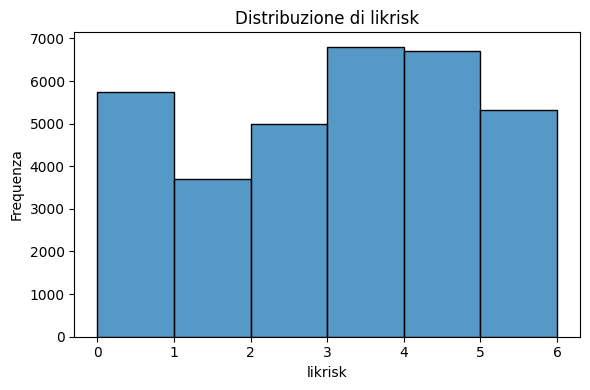

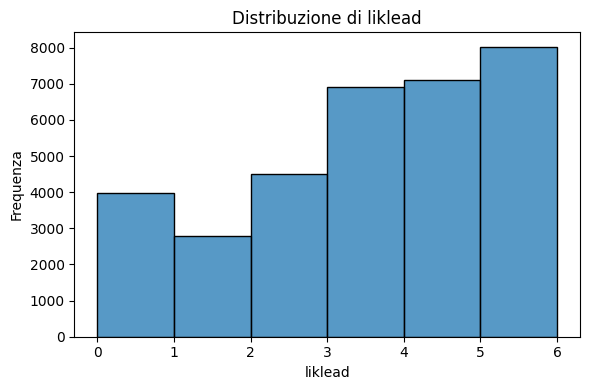

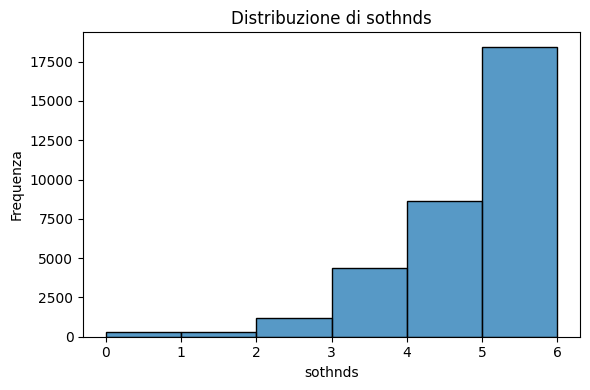

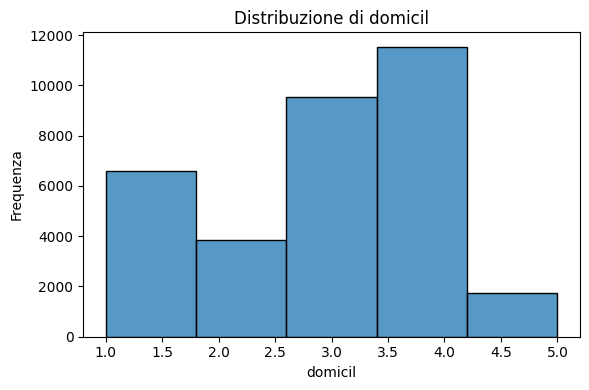

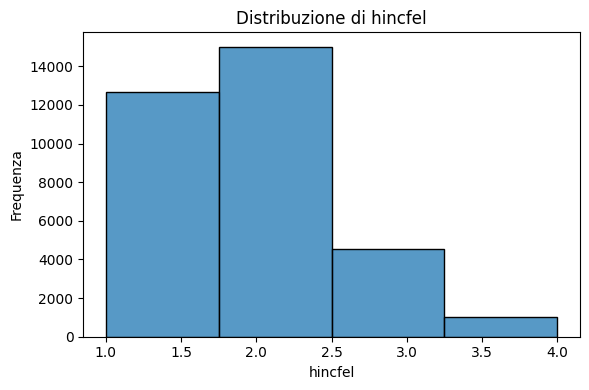

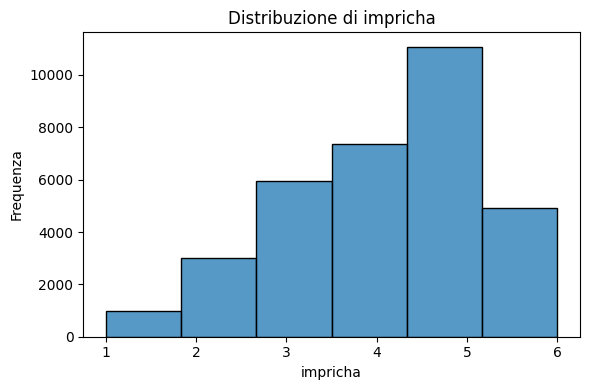

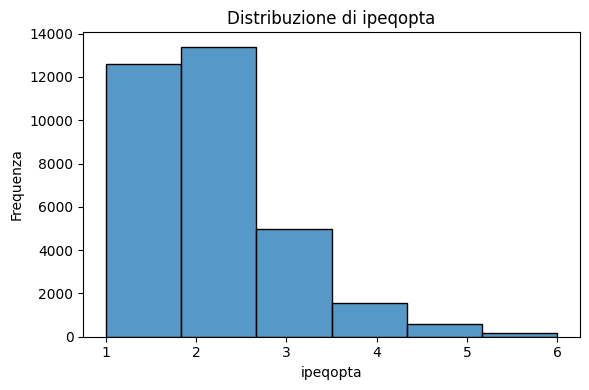

In [ ]:
for col in df_selected.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_selected[col], bins=max(df_selected[col]))
    plt.title(f'Distribuzione di {col}')
    plt.xlabel(col)
    plt.ylabel('Frequenza')
    plt.tight_layout()
    plt.show()

Utilizziamo i boxplot per visualizzare la mediana, il range e gli outlier per ciascuna feature.

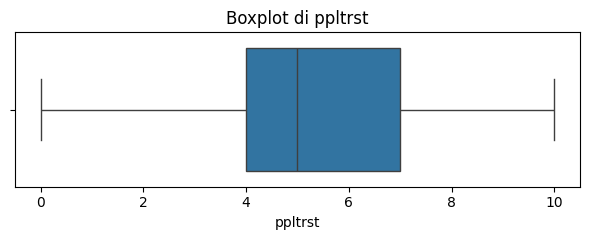

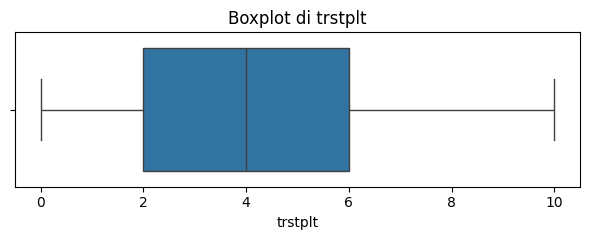

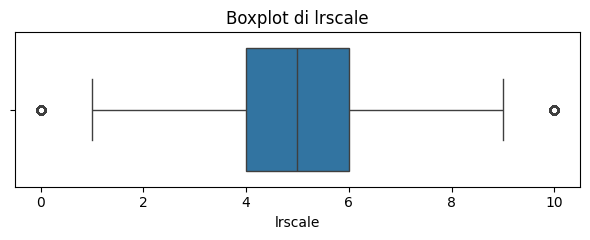

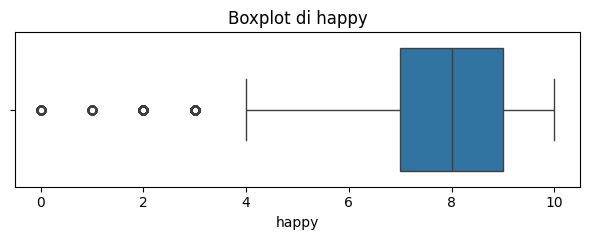

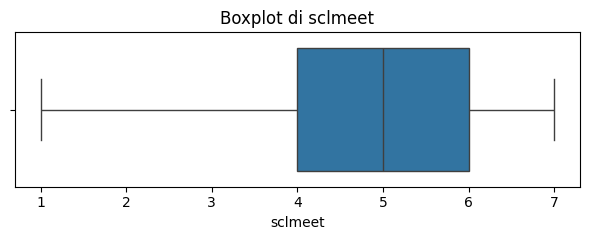

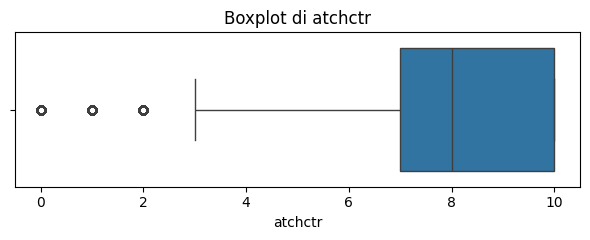

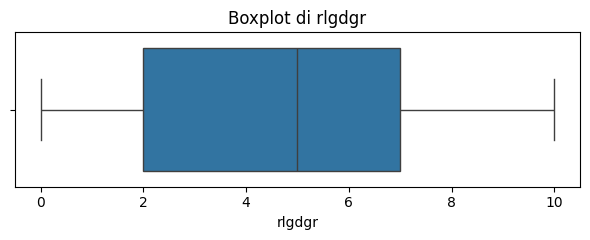

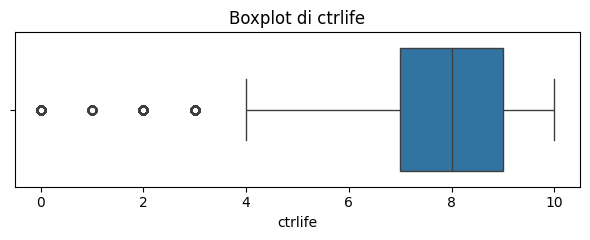

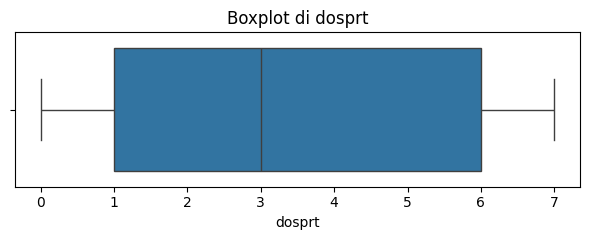

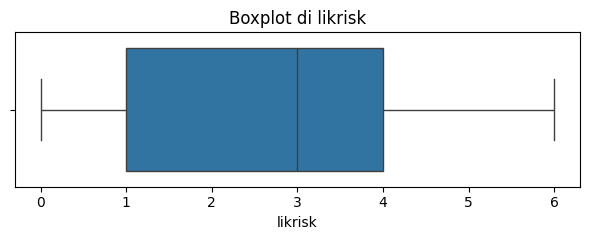

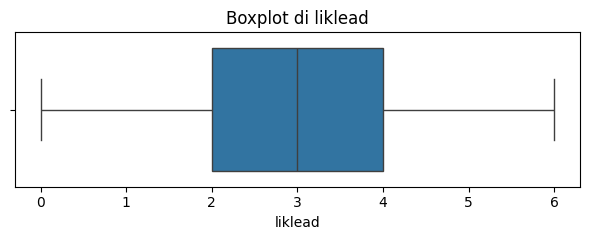

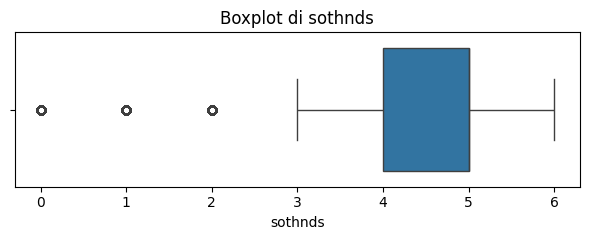

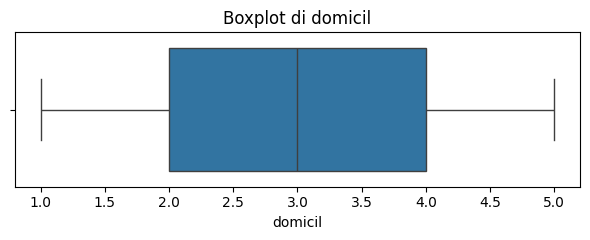

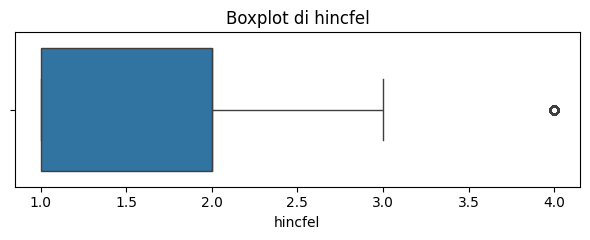

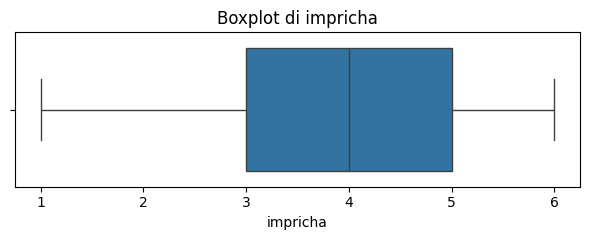

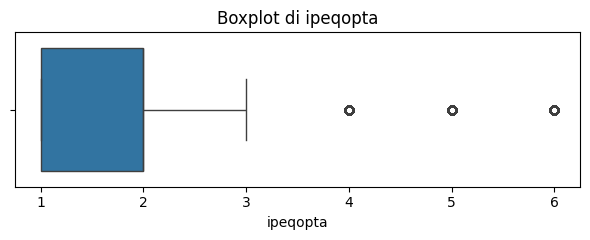

In [ ]:
for col in df_selected.columns:
    plt.figure(figsize=(6, 2.5))
    sns.boxplot(x=df_selected[col])
    plt.title(f'Boxplot di {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

# Clustering con K-means

Utilizziamo innanzitutto il cosiddetto *elbow method* per scegliere il miglior k per kmeans. Il metodo consiste nel calcolare, per ogni k in un range da 1 a n, una distanza chiamata Within-Cluster Sum of Squares (WCSS), che misura quanto bene i dati si raggruppano attorno ai rispettivi centroidi. Plottiamo il grafico della WCSS al variare di k, e identifichiamo il cosiddetto *Elbow Point*, ossia quello in cui il tasso di diminuzione della WCSS cambia drasticamente.

Poiché i nostri dati sono su scale diverse, prima di proseguire normalizziamo i dati con lo Standard Scaler.

In [ ]:
# Normalizziamo i dati
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_selected), columns=df_selected.columns)


Applichiamo ora l'Elbow Method.

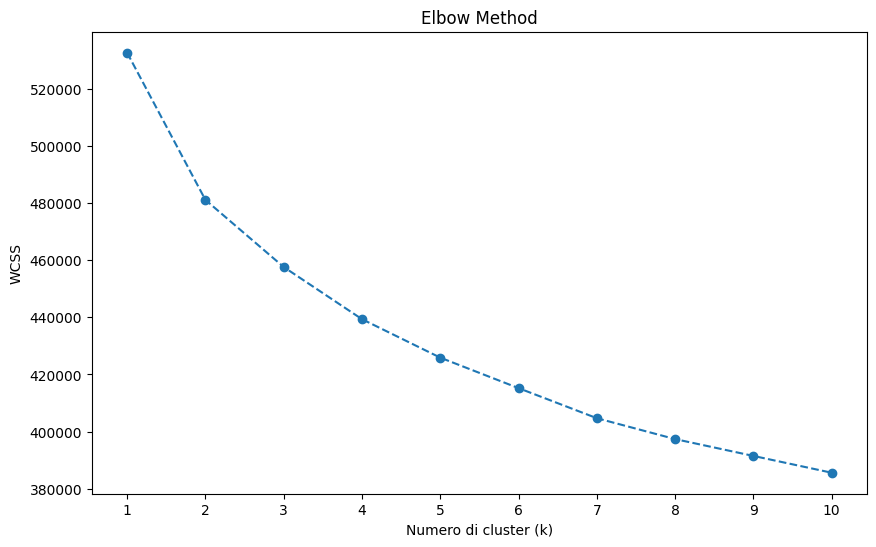

In [ ]:
# Applichiamo l'Elbow Method
wcss = []
# Proviamo k da 1 a 10
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph.
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.show()

Sembra che dopo k=3 il cambiamento smetta di essere significativo.

In [ ]:
k = 3

# Applichiamo K-means
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(df_scaled)

# Aggiungiamo l'etichetta al dataframe originale
df_labeled = df_scaled.copy()
df_labeled['cluster'] = clusters

df_selected['cluster'] = clusters

Adesso stampiamo i centroidi per ogni cluster. Ricordiamo che qui i dati sono stati normalizzati. Possiamo comunque osservare in cosa differiscono maggiormente tra loro i vari cluster.

In [ ]:
# Stampa i centroidi per ogni feature per ogni cluster
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df_scaled.columns)

print('Centroidi per ciascun cluster:')
centroids


Centroidi per ciascun cluster:


,ppltrst,trstplt,lrscale,happy,sclmeet,atchctr,rlgdgr,ctrlife,dosprt,likrisk,liklead,sothnds,domicil,hincfel,impricha,ipeqopta
0,0.073368,0.094286,0.070753,0.330483,-0.018385,0.394570,0.331895,0.326686,-0.140120,-0.752255,-0.706497,0.139218,0.260945,-0.056486,0.440128,-0.130378
1,-0.572144,-0.495595,-0.083153,-0.964570,-0.549149,-0.368241,0.004215,-0.792065,-0.397778,-0.142206,-0.284417,-0.447305,-0.096998,0.710426,-0.181512,0.317933
2,0.298296,0.238030,0.003554,0.365929,0.345125,-0.038070,-0.222378,0.263855,0.333978,0.584458,0.640374,0.178993,-0.114021,-0.393318,-0.181458,-0.106409


Stampiamo la media di ciascuna feature per ogni centroide. In questo modo possiamo confrontare la media con la media generale.

In [ ]:
# Calcoliamo la media per ogni feature, per ogni cluster
cluster_means = df_selected.groupby('cluster')[selected_columns].mean()

print('Medie per ogni feature:')
print(df_selected.mean())
print('Media per cluster per ciascuna feature:')
cluster_means

Medie per ogni feature:
ppltrst     5.288556
trstplt     3.859448
lrscale     5.033501
happy       7.558303
sclmeet     4.824175
atchctr     7.912027
rlgdgr      4.699005
ctrlife     7.499264
dosprt      3.291500
likrisk     2.687708
liklead     3.115615
sothnds     4.507556
domicil     2.940630
hincfel     1.817685
impricha    4.180212
ipeqopta    1.935883
cluster     1.148815
dtype: float64
Media per cluster per ciascuna feature:


,ppltrst,trstplt,lrscale,happy,sclmeet,atchctr,rlgdgr,ctrlife,dosprt,likrisk,liklead,sothnds,domicil,hincfel,impricha,ipeqopta
cluster,,,,,,,,,,,,,,,,
0,5.456631,4.084885,5.190863,8.125116,4.793703,8.749871,5.740097,8.119560,2.925918,1.345612,1.866241,4.675275,3.255376,1.774565,4.751826,1.809137
1,3.941296,2.651709,4.848965,5.897548,3.978295,7.127980,4.708727,5.995389,2.263495,2.438259,2.615272,3.964687,2.822650,2.372245,3.943545,2.246176
2,5.993730,4.442067,5.041099,8.189340,5.357007,7.832197,4.003476,7.999796,4.156693,3.727917,4.246456,4.725463,2.803640,1.510155,3.944997,1.831788


Confrontando i valori ottenuti con la media generale di ciascuna feature, possiamo dire che:

*   **Cluster 0**: hanno una fiducia nei confronti delle persone e dei politici sopra la media. Sono i più patriottici e i più religiosi. Credono più degli altri nell'importanza della ricchezza e meno degli altri nell'importanza dell'equità. Sono piuttosto felici.
*   **Cluster 1**: felicità ben sotto la media. Isolati socialmente, scarsissima fiducia negli altri e nei politici. Situazione economica peggiore della media, credono di più nell'importanza dell'equità.
*   **Cluster 2**: i più felici e fiduciosi in assoluto. Sono anche i meno religiosi e i più sportivi, amanti del rischio. Situazione economica migliore della media.


Per vedere se la nostra interpretazione è corretta, useremo delle tecniche di spiegabilità per conoscere quali feature impattano maggiormente la predizione di un modello di apprendimento supervisionato addestrato sui dati etichettati.

# Random Forest e spiegabilità

Report di Classificazione:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2871
           1       0.91      0.85      0.88      2683
           2       0.92      0.94      0.93      4431

    accuracy                           0.91      9985
   macro avg       0.90      0.90      0.90      9985
weighted avg       0.91      0.91      0.91      9985



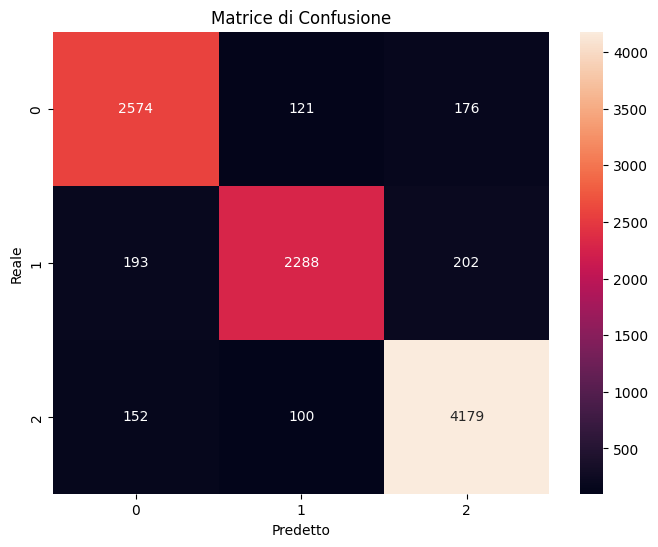

In [ ]:
# Dividi il dataframe in training e test set
X = df_labeled.drop('cluster', axis=1)
y = df_labeled['cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Addestra il modello Random Forest con parametri standard
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Prevedi sul test set
y_pred = rf.predict(X_test)

# Stampa le metriche di classificazione
print('Report di Classificazione:')
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matrice di Confusione')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.show()

L'accuratezza e l'F1 del modello sono molto alte (>=90), quindi possiamo considerare il modello abbastanza fedele al clustering di K-means. Stampiamo adesso le feature importance individuate dal modello stesso.

Importanza delle Feature (Random Forest):
liklead     0.158670
likrisk     0.147901
happy       0.132367
ctrlife     0.083980
hincfel     0.057829
ppltrst     0.047735
rlgdgr      0.047609
sclmeet     0.047565
dosprt      0.047322
atchctr     0.044079
impricha    0.039920
trstplt     0.038931
sothnds     0.032454
domicil     0.025922
lrscale     0.025030
ipeqopta    0.022687
dtype: float64


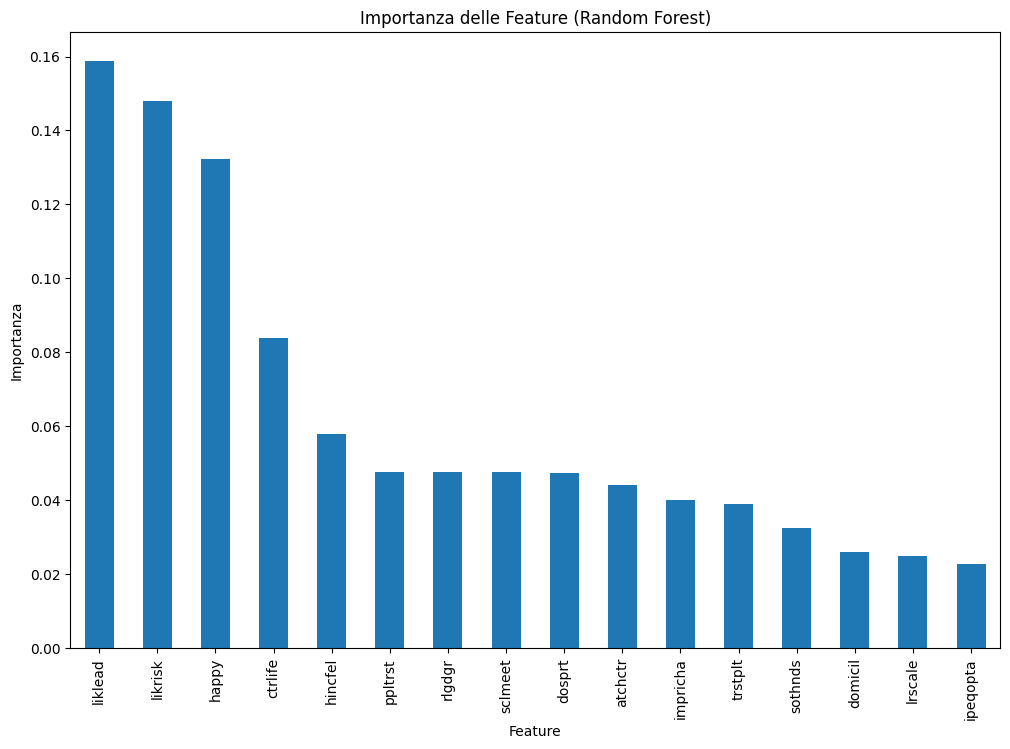

In [ ]:
# Otteniamo l'importanza delle feature dal modello Random Forest
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Stampiamo l'importanza delle feature
print('Importanza delle Feature (Random Forest):')
print(feature_importances)

# Visualizziamo l'importanza delle feature con un grafico a barre
plt.figure(figsize=(12, 8))
feature_importances.plot(kind='bar')
plt.title('Importanza delle Feature (Random Forest)')
plt.xlabel('Feature')
plt.ylabel('Importanza')
plt.show()

La feature importance si basa su quante volte ciascuna feature viene usata per la split (cioè quante volte fornisce il maggior information gain). Per ottenere una spiegazione più completa dovremo servirci di altre tecniche.

Utilizziamo SHAP per ottenere una prima spiegazione del contributo di ciascuna feature alla predizione. È particolarmente adatto per Random Forest grazie al TreeExplainer. Infatti, non solo può fornirci una visione globale, ma è anche più resistente alle correlazioni tra feature.

 99%|===================| 594/600 [01:04<00:00]       

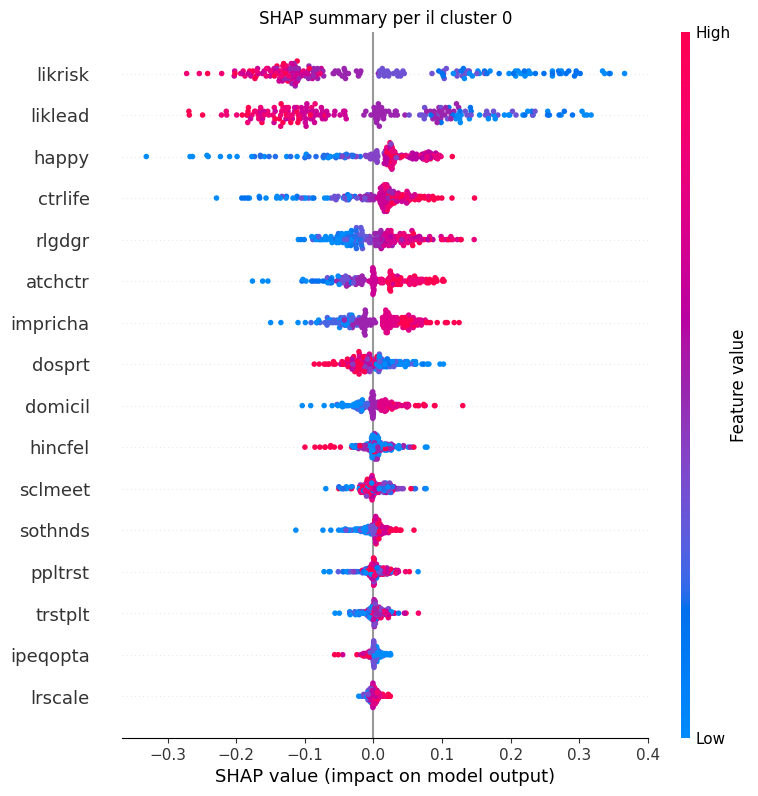

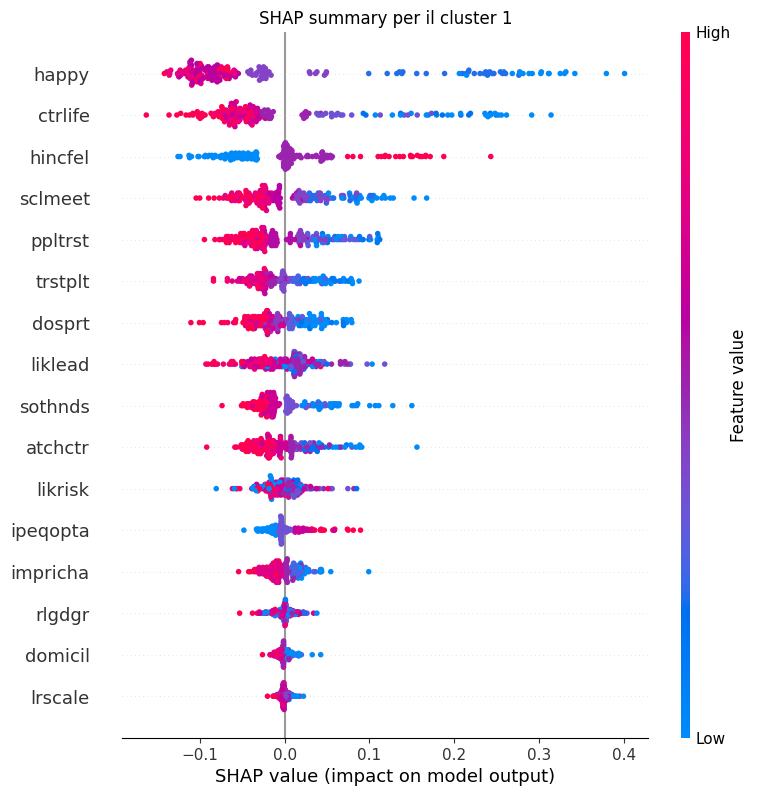

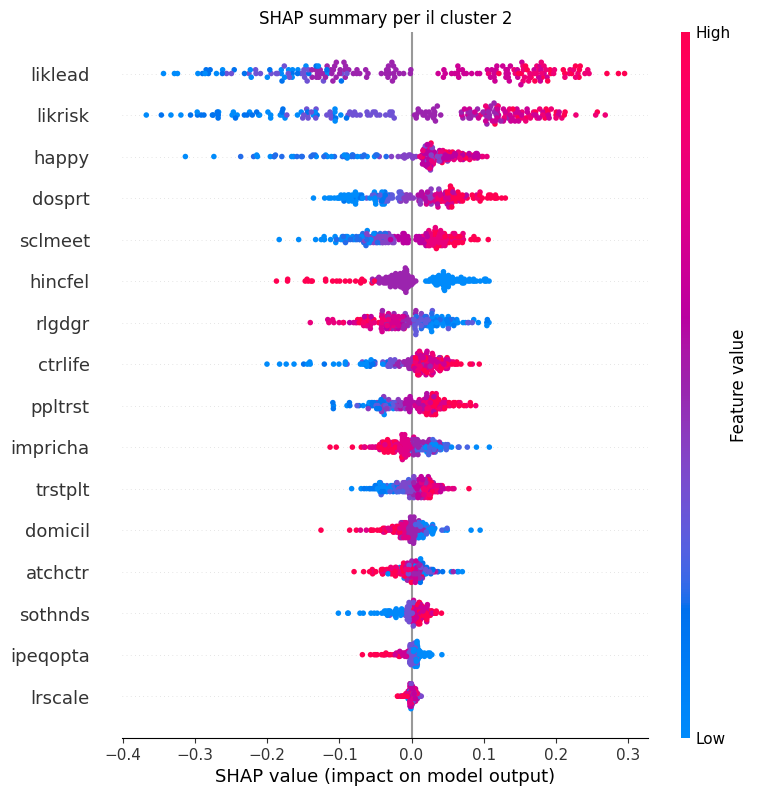

In [ ]:
# Istanziamo l'explainer
# Selezioniamo solo un campione del training set per velocizzare l'esecuzione
background = X_train.sample(n=200, random_state=42)
tree_explainer = shap.TreeExplainer(rf, data=background)


#Calcoliamo i valori SHAP per il training set
shap_values = tree_explainer.shap_values(background, check_additivity=False)

# Dobbiamo trasporre shap_values in modo tale che il plot funzioni
shap_values = np.transpose(shap_values, (2, 0, 1))

# Visualizziamo il summary plot per ciascun cluster
for cluster_id in range(len(shap_values)):
    shap.summary_plot(
        shap_values[cluster_id],
        background,
        feature_names=selected_columns,
        show=False
    )
    plt.title(f'SHAP summary per il cluster {cluster_id}')
    plt.show()

Adesso utilizziamo le feature più rilevanti per SHAP per visualizzare i PDP per ciascun cluster. In questo modo possiamo verificare il trend medio sull'intero dataset.

Top 3 feature per cluster 0 secondo SHAP: ['likrisk', 'liklead', 'happy']


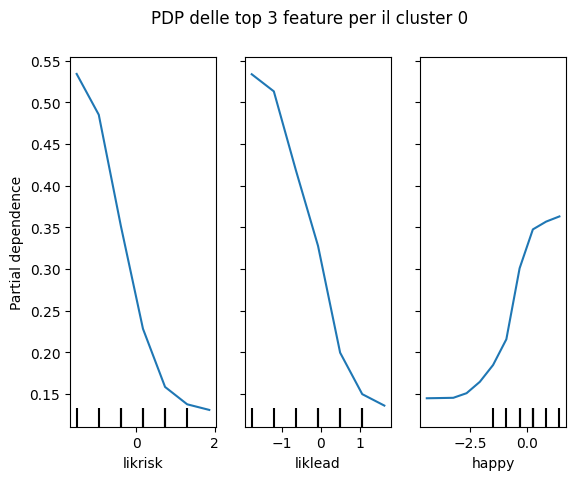

Top 3 feature per cluster 1 secondo SHAP: ['happy', 'ctrlife', 'hincfel']


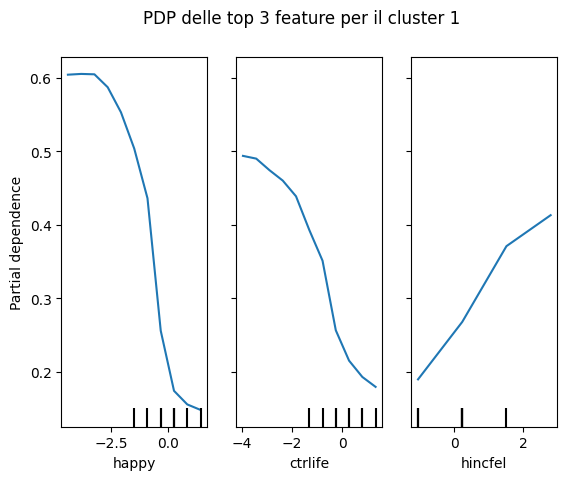

Top 3 feature per cluster 2 secondo SHAP: ['liklead', 'likrisk', 'happy']


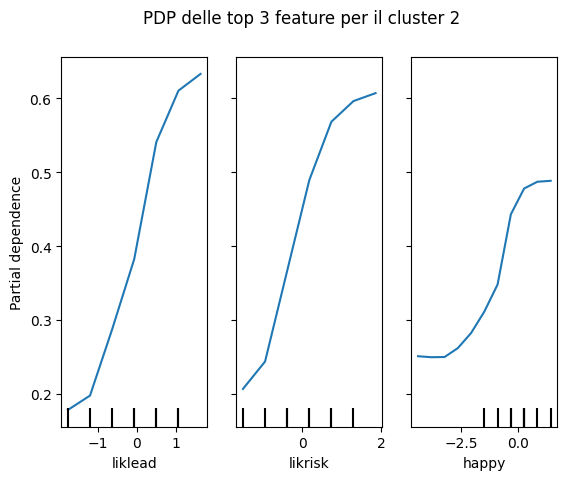

In [ ]:
num_features = 3

for cluster_id in range(len(shap_values)):
  # Calcoliamo l'importanza media assoluta per ciascuna feature
  importances = np.mean(np.abs(shap_values[cluster_id]), axis=0)

  # Ordiniamo le features per importanza e prendiamo le prime 3
  feat_imp = pd.Series(importances, index=selected_columns)
  top_features = feat_imp.sort_values(ascending=False).head(num_features).index.tolist()

  print(f'Top {num_features} feature per cluster {cluster_id} secondo SHAP:', top_features)

  # Visualizziamo i PDP
  PartialDependenceDisplay.from_estimator(
      rf,
      X_train,
      features=top_features,
      target=cluster_id,
      kind='average'
  )
  plt.suptitle(f'PDP delle top {num_features} feature per il cluster {cluster_id}')
  plt.show()



Quindi i valori shap sembrano essere coerenti con i trend globali.

Adesso vediamo come cambia la spiegazione locale su delle istanze specifiche, una per classe, rispetto a quella globale.

In [ ]:
# Definiamo una funzione di supporto per spiegare un singolo elemento del test set
def lime_explain(model, explainer, X, y, idx):
  # Selezioniamo l'istanza da spiegare e l'etichetta associata
  # Usiamo il positional index per selezionare la riga da X_test e y_test
  instance = X.iloc[[idx]]
  # Passiamo l'array numpy per LIME
  instance_array = X.iloc[idx].values
  label = y.iloc[[idx]]

  # Salviamo la predizione del modello
  label_pred = model.predict(instance)[0]

  # Stampiamo l'istanza da spiegare, l'etichetta vera e quella predetta
  print(f'Spiegazione per l\'istanza {idx}, appartenente al cluster {label.iloc[0]}') # Access the scalar value of the label
  print(f'\nPredizione del modello: {label_pred}')

  # Generiamo la spiegazione
  num_features= len(selected_columns)

  explanation = explainer.explain_instance(
      data_row=instance_array,
      predict_fn=model.predict_proba,
      num_features=num_features,
      top_labels=4
  )
  # Plottiamo l'importanza delle feature
  explanation.as_pyplot_figure()
  plt.title('Spiegazione locale')
  plt.show()

# Istanziamo l'explainer LIME
# Passiamo i valori numpy del training set all'explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, # Pass numpy values here
    feature_names=selected_columns,
    class_names=[0, 1, 2, 3],
    mode='classification',
    random_state=42,
    discretize_continuous=True
)

Adesso spieghiamo un'istanza per classe.

Spiegazione per l'istanza 1, appartenente al cluster 0

Predizione del modello: 0


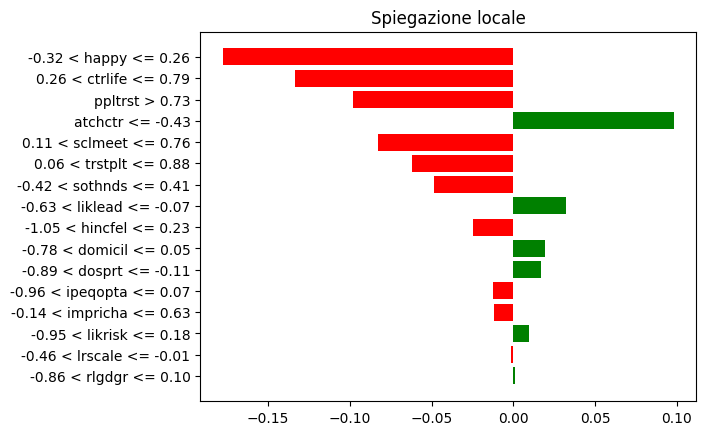

In [ ]:
# Cluster 0
lime_explain(rf, lime_explainer, X_test, y_test, 1)

Spiegazione per l'istanza 0, appartenente al cluster 1

Predizione del modello: 1


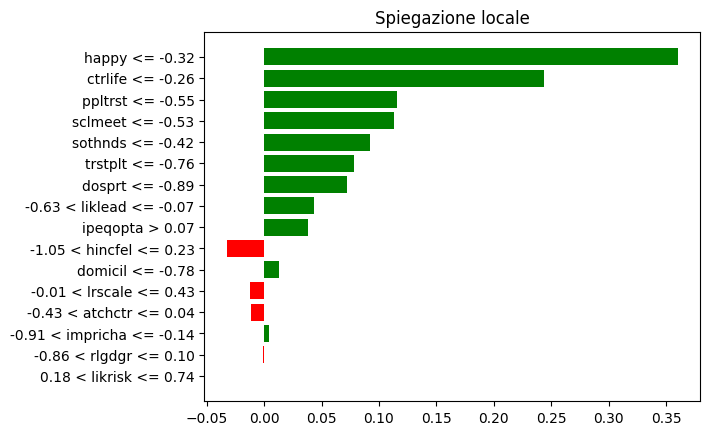

In [ ]:
# Cluster 1
lime_explain(rf, lime_explainer, X_test, y_test, 0)

Spiegazione per l'istanza 2, appartenente al cluster 2

Predizione del modello: 2


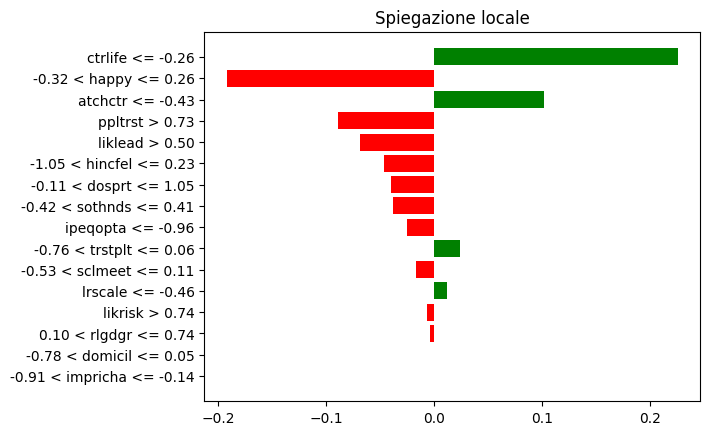

In [ ]:
# Cluster 2
lime_explain(rf, lime_explainer, X_test, y_test, 2)

LIME dà una spiegazione locale: per ciascuna istanza, ci dice quali sono le feature che hanno contribuito maggiormente alla specifica predizione del modello. Infatti, i grafici ci mostrano che la spiegazione data è molto diversa da quella globale di SHAP e dai trend globali dei PDP (tranne per il cluster 1).

Notiamo che sono diverse anche dalla feature importance calcolata da Random Forest: tra le feature che hanno contribuito maggiormente alla specifica predizione nei tre casi visti vi sono feature a cui RF dà effettivamente grande importanza ('happy', 'ctrlife'), ma 'likrisk' e 'liklead', che sono le più importanti per RF, non sono altrettanto importanti nelle predizioni delle istanze specifiche.

In ogni caso, sia la feature importance di RF che la spiegazione locale di LIME non mostrano quelli che sono i trend globali su tutto il dataset. Per questo è bene confrontare più tecniche per la spiegabilità, sia globali che locali.

# Limiti

Un primo limite del presente progetto risiede nella natura stessa delle feature utilizzate: gran parte delle variabili provengono da scale Likert ordinali; K-means assume però che le feature siano continue. La metrica utilizzata, che è la distanza euclidea, è solitamente sconsigliata per le feature su scala Likert; tuttavia, possiamo assumere che la distanza concettuale tra un numero e l'altro nella scala Likert sia la stessa (quindi, per esempio, la distanza concettuale tra 'neutrale' e 'abbastanza' è la stessa che c'è tra 'neutrale' e 'poco'). Inoltre, le feature sono state normalizzate.

In secondo luogo, la scelta di k resta in parte soggettiva e sensibile alla scala dei dati. Si potrebbe decidere di usare altre metriche e metodi per scegliere il numero di cluster in modo più oggettivo. Tuttavia, il focus del progetto non è sul clustering di per sé, ma sulla spiegabilità dei modelli di machine learning.

Infine, utilizziamo Random Forest come un modello surrogato, e questo aggiunge un ulteriore livello di approssimazione: sebbene ne misuriamo la fedeltà, dobbiamo essere consapevoli del fatto che le spiegazioni SHAP e LIME riflettono la logica del surrogato piuttosto che i calcoli originali di K-means, introducendo possibili bias.